In [1]:
!pip install xgboost

In [5]:
!pip install impyute

In [6]:
import sys

import pandas as pd
import numpy as np

import missingno as msno
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from scipy import stats as st
from statsmodels import api as sm

from impyute.imputation.cs import fast_knn

from tqdm import tqdm

# Data Cleaning
### Question 0: Open your document with a brief statement as to how you handled dimension reduction, data cleaning and data transformation, as this will apply to all answers. Make sure to include your name. 

In [7]:
data = pd.read_csv('movieReplicationSet.csv')

# Movie ratings for the 400 columns of movies
movie = data.iloc[:,0:400]

# Characteristic data columns
sensation_seeking = data.iloc[:,400:420]
personality = data.iloc[:,420:464]
movie_experience = data.iloc[:,464:474]

# Gender identity data
gender_identity = data.iloc[:,474]

# Only child data
sibship = data.iloc[:,475]

# Social viewing preference data
viewing_preference = data.iloc[:,476]

<AxesSubplot:>

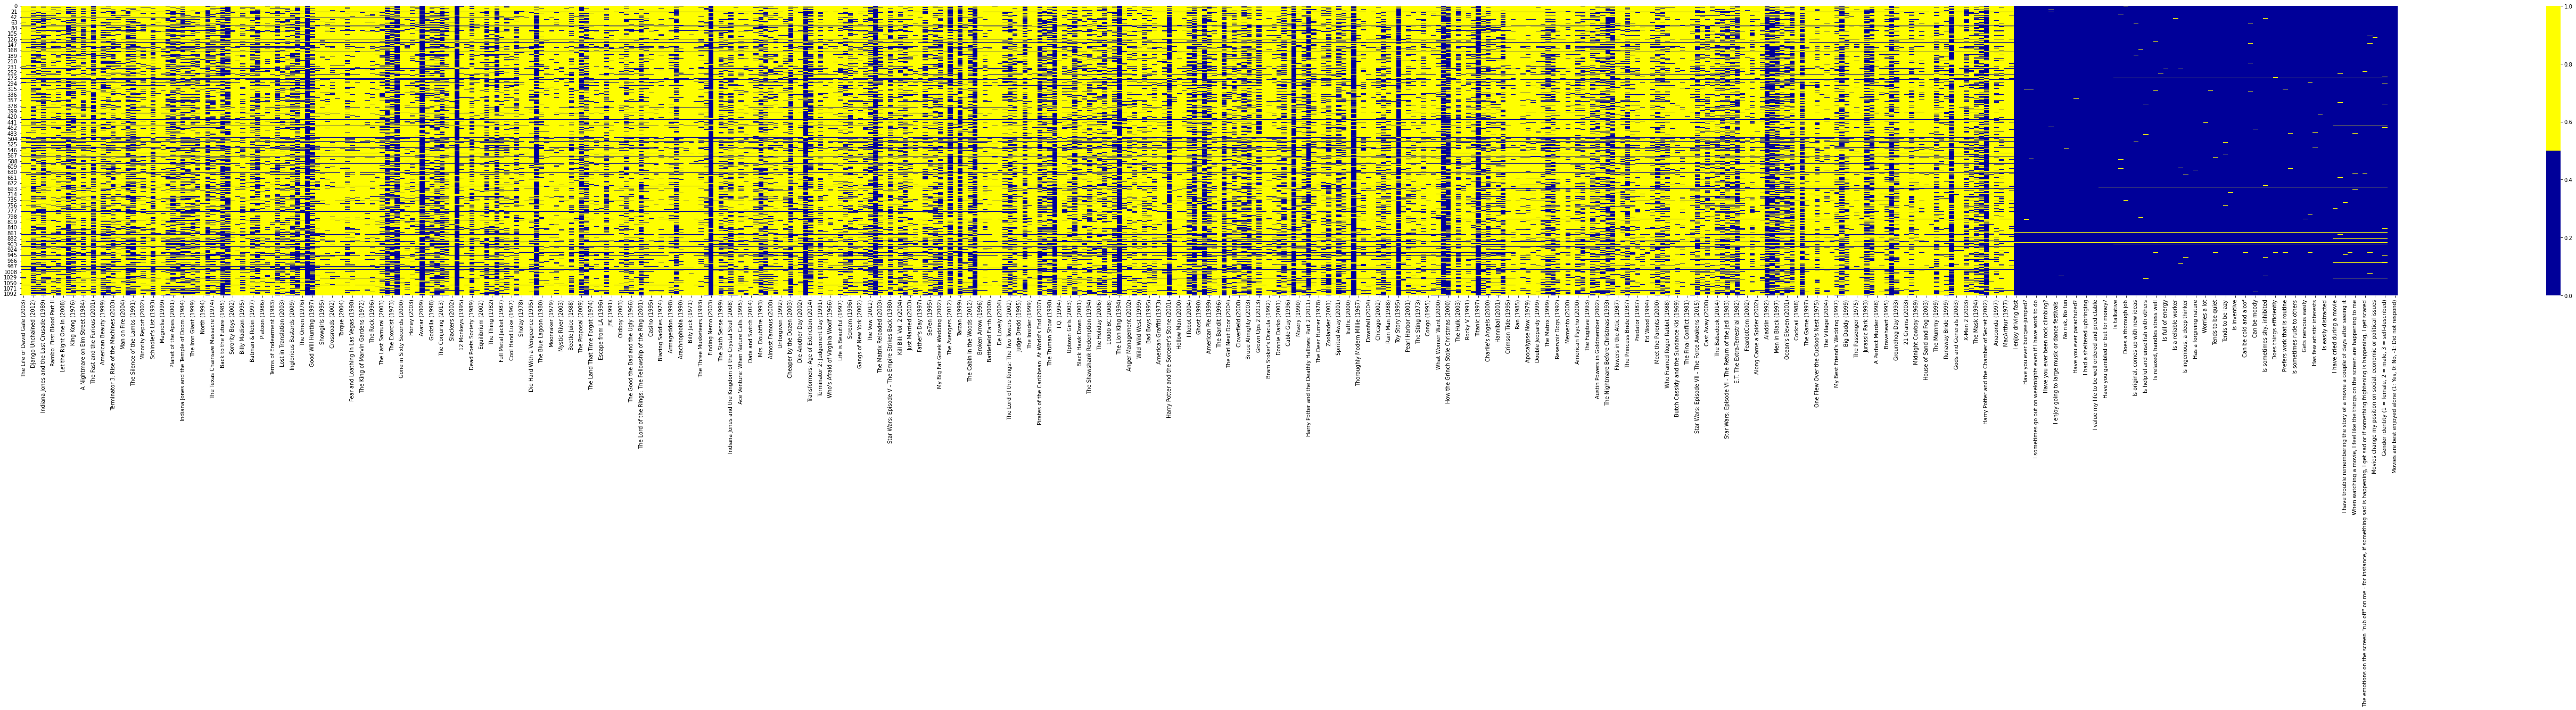

In [8]:
colors = ['#000099', '#ffff00']
fig, ax = plt.subplots(figsize=(100,10))

sns.heatmap(data.isnull(), cmap=sns.color_palette(colors), ax=ax)

<AxesSubplot:>

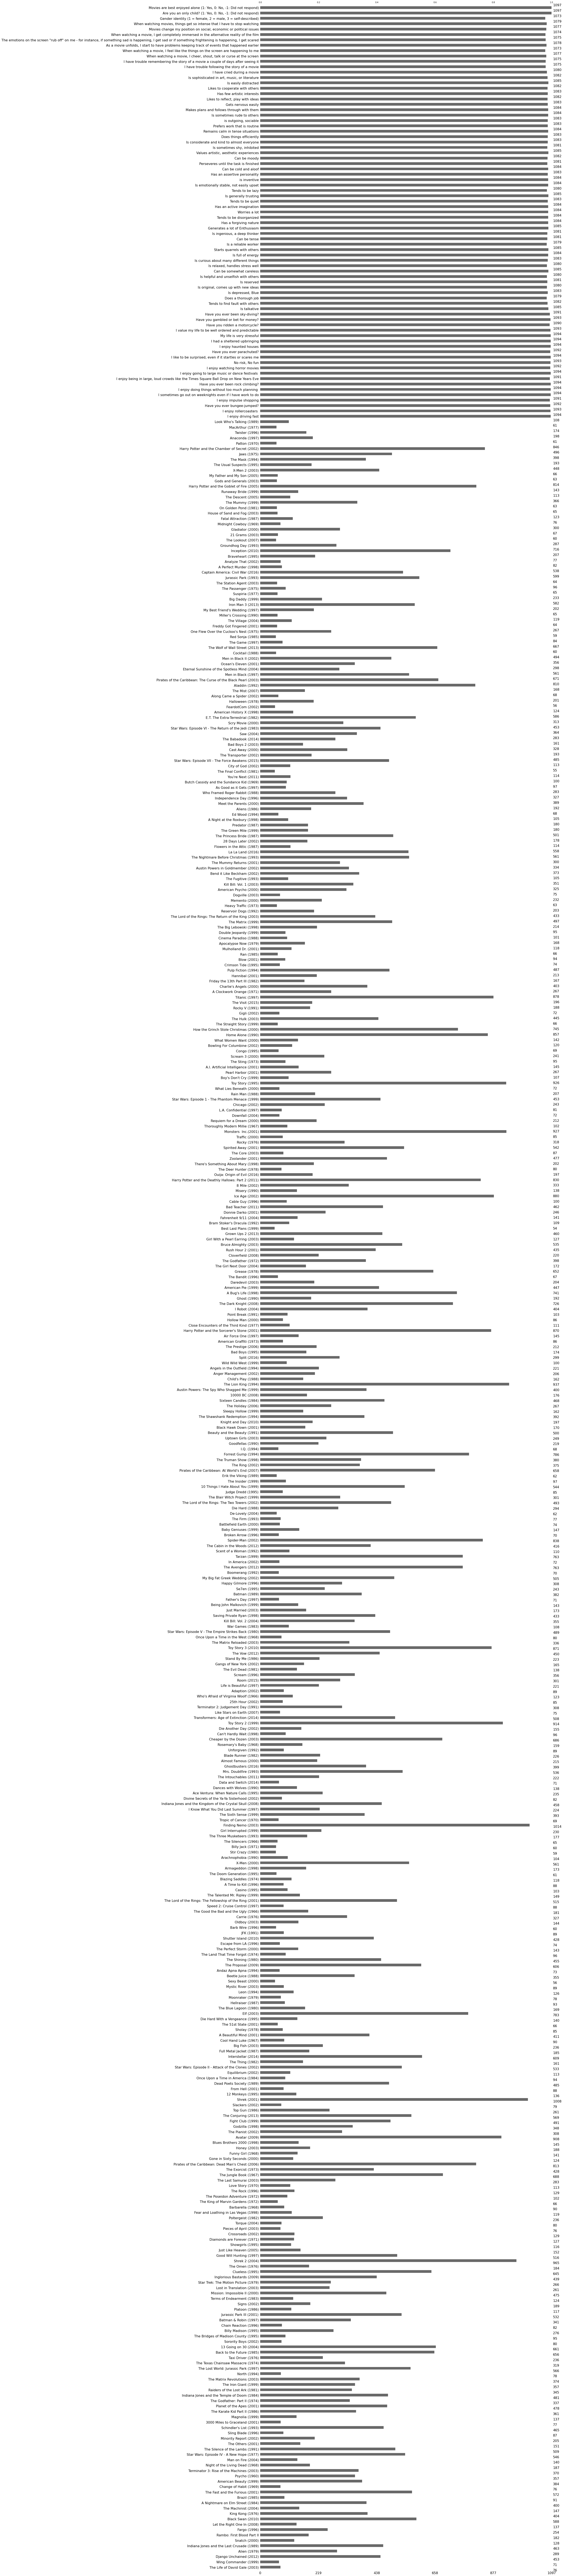

In [9]:
msno.bar(data)

<AxesSubplot:>

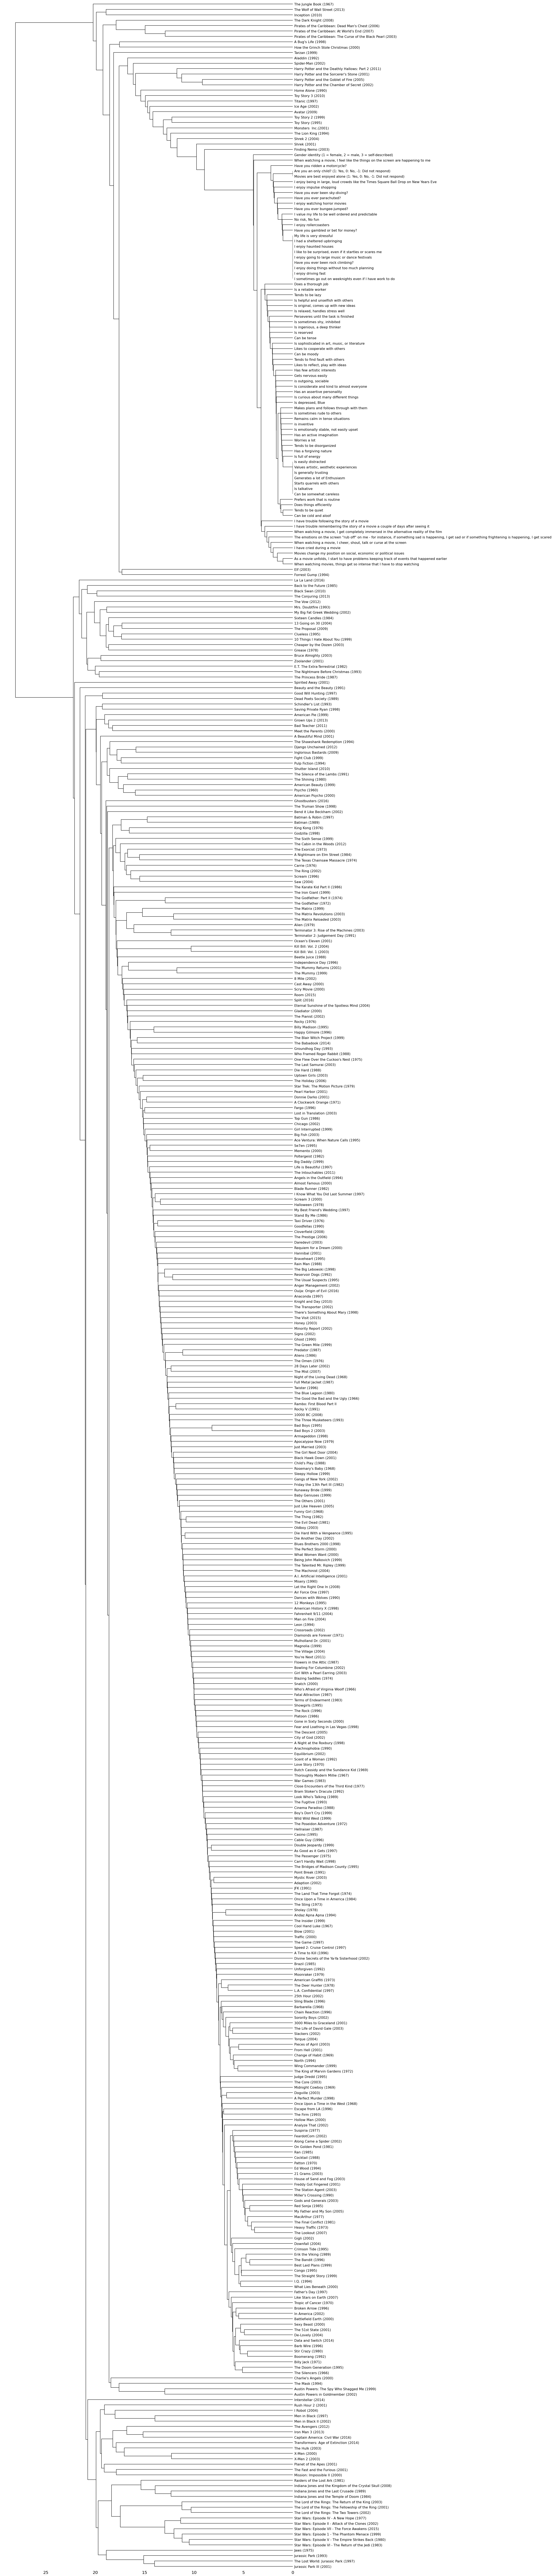

In [10]:
msno.dendrogram(data)

* For dimensional reduction, the process was only carried out on non-movie ratings data, specifically the characteristic data columns, the gender identity column, the only-child column, and the social viewing preference column. The method implemented was the PCA, with further uses being made on movies data as required.

* For data cleaning, a mix between imputation and row-wise removal was implemented. The reasoning behind this was motivated by the cause of the missing values as "item non-response," with movie ratings themselves being sparse across all 400 columns, but latter survey questions having few missing responses (removed in place, across all features). With the fact that these characteristics are designed to be unique, a k-NN imputation method was implemented on them, by creating a basic mean impute then using the resulting complete list to construct a KDTree. It then uses the resulting KDTree to compute nearest neighbours (NN). After it finds the k-NNs, it takes the weighted average of them. Information was obtained from (https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)

* Data transformation was carried out on a need-be basis, based on the previous actions of dimensional reduction and data cleaning (on a basis consistent to the question)

# PCA Portion
### Question 1: What is the relationship between sensation seeking and movie experience?
#### For the duration of this question, 1 is sensation seeking, 2 is movie experience, 3 is personality

##### Sensation Seeking PCA

In [11]:
# Initiates k-NN imputation across the sensation seeking characteristic
sys.setrecursionlimit(100000)
sensation_seeking_impute = fast_knn(sensation_seeking.values, k=100)
sensation_seeking_impute = pd.DataFrame(sensation_seeking_impute, columns=sensation_seeking.columns)

In [12]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

z_scored1 = st.zscore(sensation_seeking_impute)

pca1 = PCA().fit(z_scored1)
eig_vals1 = pca1.explained_variance_
loadings1 = pca1.components_
rotated_data1 = pca1.fit_transform(z_scored1)

covar_explained1 = eig_vals1 / sum(eig_vals1) * 100

for n in range(len(covar_explained1)):
    explained1 = covar_explained1[n].round(5)
    print(f'The {ordinal(n)} PC explains {explained1}% of the variance')

The 0th PC explains 17.43026% of the variance
The 1st PC explains 8.81229% of the variance
The 2nd PC explains 8.17538% of the variance
The 3rd PC explains 6.53879% of the variance
The 4th PC explains 5.72687% of the variance
The 5th PC explains 5.22916% of the variance
The 6th PC explains 4.99421% of the variance
The 7th PC explains 4.84126% of the variance
The 8th PC explains 4.50097% of the variance
The 9th PC explains 4.30587% of the variance
The 10th PC explains 3.95657% of the variance
The 11th PC explains 3.75336% of the variance
The 12th PC explains 3.70507% of the variance
The 13th PC explains 3.31646% of the variance
The 14th PC explains 3.09153% of the variance
The 15th PC explains 2.9475% of the variance
The 16th PC explains 2.73117% of the variance
The 17th PC explains 2.55229% of the variance
The 18th PC explains 1.73418% of the variance
The 19th PC explains 1.65683% of the variance


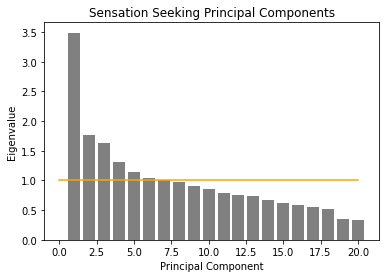

In [13]:
num_quest = len(sensation_seeking_impute.columns)
x = np.linspace(1,num_quest, num_quest)
plt.bar(x, eig_vals1, color='gray')
plt.plot([0,num_quest], [1,1], color='orange')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Sensation Seeking Principal Components')
plt.show()

In [14]:
threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals1 > threshold))

print('Number of factors selected by elbow criterion: 1')

threshold = 90
eig_sum1 = np.cumsum(covar_explained1)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum1 < threshold) + 1)

Number of factors selected by Kaiser criterion: 6
Number of factors selected by elbow criterion: 1
Number of factors to account for at least 90% variance: 16


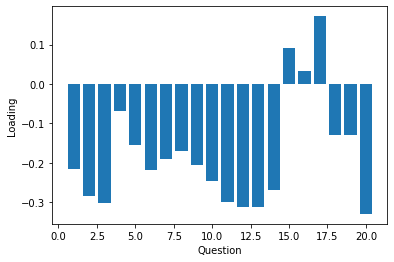

Principal component 1: I enjoy driving fast
Principal component 2: I enjoy rollercoasters 
Principal component 3: Have you ever bungee-jumped?
Principal component 4: I enjoy impulse shopping
Principal component 5: I sometimes go out on weeknights even if I have work to do
Principal component 6: I enjoy doing things without too much planning 
Principal component 7: Have you ever been rock climbing?
Principal component 8: I enjoy being in large, loud crowds like the Times Square Ball Drop on New Years Eve
Principal component 9: I enjoy going to large music or dance festivals 
Principal component 10: I enjoy watching horror movies
Principal component 11: No risk, No fun
Principal component 12: I like to be surprised, even if it startles or scares me
Principal component 13: Have you ever parachuted?
Principal component 14: I enjoy haunted houses
Principal component 15: I had a sheltered upbringing
Principal component 16: My life is very stressful
Principal component 17: I value my life to 

In [15]:
PC = 0 # Which PC to take a look at
plt.bar(x, loadings1[PC,:] * -1)
plt.xlabel('Question')
plt.ylabel('Loading')
plt.show()
for index in range(len(sensation_seeking.columns)):
    print(f'Principal component {index+1}: {sensation_seeking.columns[index]}')

##### Movie Experience PCA

In [16]:
# Initiates k-NN imputation across the movie experience characteristic
sys.setrecursionlimit(100000)
movie_experience_impute = fast_knn(movie_experience.values, k=100)
movie_experience_impute = pd.DataFrame(movie_experience_impute, columns=movie_experience.columns)

In [17]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

z_scored2 = st.zscore(movie_experience_impute)

pca2 = PCA().fit(z_scored2)
eig_vals2 = pca2.explained_variance_
loadings2 = pca2.components_
rotated_data2 = pca2.fit_transform(z_scored2)

covar_explained2 = eig_vals2 / sum(eig_vals2) * 100

for n in range(len(covar_explained2)):
    explained = covar_explained2[n].round(5)
    print(f'The {ordinal(n)} PC explains {explained}% of the variance')

The 0th PC explains 29.29499% of the variance
The 1st PC explains 18.81829% of the variance
The 2nd PC explains 8.88431% of the variance
The 3rd PC explains 8.58652% of the variance
The 4th PC explains 7.72074% of the variance
The 5th PC explains 6.96551% of the variance
The 6th PC explains 5.72894% of the variance
The 7th PC explains 5.51736% of the variance
The 8th PC explains 4.36436% of the variance
The 9th PC explains 4.119% of the variance


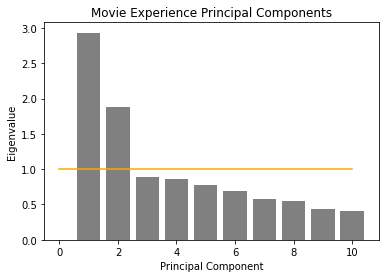

In [18]:
num_quest = len(movie_experience_impute.columns)
x = np.linspace(1,num_quest, num_quest)
plt.bar(x, eig_vals2, color='gray')
plt.plot([0,num_quest], [1,1], color='orange')
plt.title('Movie Experience Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [19]:
threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals2 > threshold))

print('Number of factors selected by elbow criterion: 2')

threshold = 90
eig_sum2 = np.cumsum(covar_explained2)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum2 < threshold) + 1)

Number of factors selected by Kaiser criterion: 2
Number of factors selected by elbow criterion: 2
Number of factors to account for at least 90% variance: 8


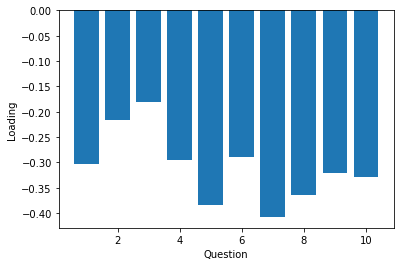

Principal component 1: I have cried during a movie
Principal component 2: I have trouble following the story of a movie
Principal component 3: I have trouble remembering the story of a movie a couple of days after seeing it
Principal component 4: When watching a movie, I cheer, shout, talk or curse at the screen
Principal component 5: When watching a movie, I feel like the things on the screen are happening to me
Principal component 6: As a movie unfolds, I start to have problems keeping track of events that happened earlier
Principal component 7: The emotions on the screen "rub off" on me - for instance, if something sad is happening, I get sad or if something frightening is happening, I get scared
Principal component 8: When watching a movie, I get completely immersed in the alternative reality of the film
Principal component 9: Movies change my position on social, economic or political issues
Principal component 10: When watching movies, things get so intense that I have to stop wat

In [20]:
PC = 0 # Which PC to take a look at
plt.bar(x, loadings2[PC,:] * -1)
plt.xlabel('Question')
plt.ylabel('Loading')
plt.show()
for index in range(len(movie_experience.columns)):
    print(f'Principal component {index+1}: {movie_experience.columns[index]}')

##### Find correlation between Sensation Seeking and Movie Experience

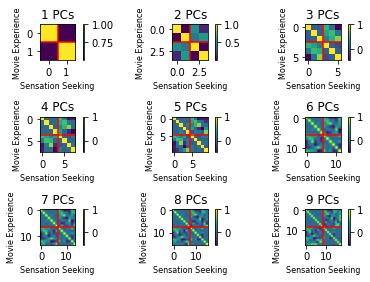

In [21]:
# Will pick one PC in order to show correlation. We can expand our analysis to more factors later on
# With a correlation matrix consisting of 

look_at = 9
for i in range(1,look_at+1):
    x = i - 0.5
    y = i - 0.5
    
    PC1 = pd.DataFrame(loadings1[:,:i])
    PC2 = pd.DataFrame(loadings2[:,:i])
    
    final_corr = pd.concat([PC1,PC2], axis=1)
    corr_matrix = final_corr.corr()
    
    plt.subplot(3,3,i)
    plt.imshow(corr_matrix)
    
    plt.axvline(x=x, color='r')
    plt.axhline(y=y, color='r')
    
    plt.xlabel('Sensation Seeking', fontsize=8)
    plt.ylabel('Movie Experience', fontsize=8)
    
    plt.title(f'{i} PCs')
    
    plt.colorbar()
    plt.tight_layout()

### Question 2: Is there evidence of personality types based on the data of these research participants? If so, characterize these types both quantitatively and narratively.

In [22]:
# We can use the dimensionally reduced dataset from the previous question
# Initiates k-NN imputation across the personality characteristic
sys.setrecursionlimit(100000)
personality_impute = fast_knn(personality.values, k=100)
personality_impute = pd.DataFrame(personality_impute, columns=personality.columns)

In [23]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

z_scored3 = st.zscore(personality_impute)

pca3 = PCA().fit(z_scored3)
eig_vals3 = pca3.explained_variance_
loadings3 = pca3.components_
rotated_data3 = pca3.fit_transform(z_scored3)

covar_explained3 = eig_vals3 / sum(eig_vals3) * 100

for n in range(len(covar_explained3)):
    explained = covar_explained3[n].round(5)
    print(f'The {ordinal(n)} PC explains {explained}% of the variance')

The 0th PC explains 15.09155% of the variance
The 1st PC explains 8.96736% of the variance
The 2nd PC explains 8.1617% of the variance
The 3rd PC explains 7.19891% of the variance
The 4th PC explains 5.6139% of the variance
The 5th PC explains 4.63933% of the variance
The 6th PC explains 2.4232% of the variance
The 7th PC explains 2.25751% of the variance
The 8th PC explains 2.06328% of the variance
The 9th PC explains 2.0487% of the variance
The 10th PC explains 1.97342% of the variance
The 11th PC explains 1.91132% of the variance
The 12th PC explains 1.86142% of the variance
The 13th PC explains 1.77903% of the variance
The 14th PC explains 1.72044% of the variance
The 15th PC explains 1.63468% of the variance
The 16th PC explains 1.61355% of the variance
The 17th PC explains 1.53814% of the variance
The 18th PC explains 1.5012% of the variance
The 19th PC explains 1.45535% of the variance
The 20th PC explains 1.44308% of the variance
The 21st PC explains 1.39035% of the variance
Th

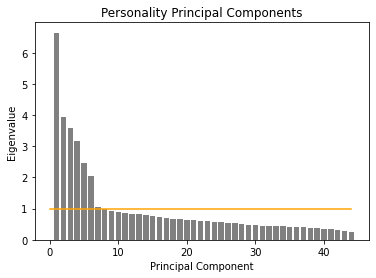

In [24]:
num_quest = len(personality_impute.columns)
x = np.linspace(1,num_quest, num_quest)
plt.bar(x, eig_vals3, color='grey')
plt.plot([0,num_quest], [1,1], color='orange')
plt.title('Personality Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [25]:
threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals3 > threshold))

print('Number of factors selected by elbow criterion: 1')

threshold = 90
eig_sum3 = np.cumsum(covar_explained3)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum3 < threshold) + 1)

Number of factors selected by Kaiser criterion: 7
Number of factors selected by elbow criterion: 1
Number of factors to account for at least 90% variance: 32


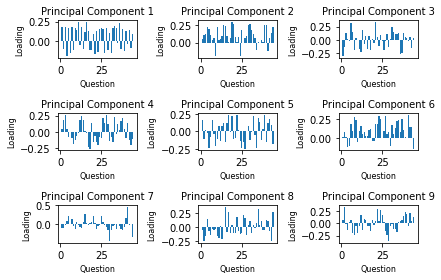

In [26]:
look_at = 9
for i in range(0,look_at):
    
    plt.subplot(3,3,i+1)
    plt.bar(x, loadings3[i,:] * -1)
    
    plt.title(f'Principal Component {i+1}', fontsize=10)
    plt.xlabel('Question', fontsize=8)
    plt.ylabel('Loading', fontsize=8)
    
    plt.tight_layout()

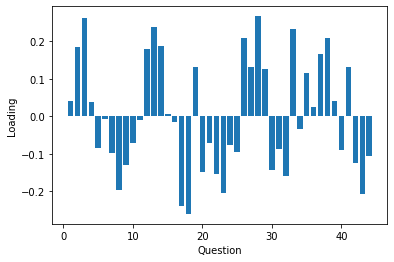

In [27]:
PC = 3 # Which PC to take a look at
plt.bar(x, loadings3[PC,:] * -1)
plt.xlabel('Question')
plt.ylabel('Loading')
plt.show()

In [28]:
for i in range(len(personality.columns)):
    print(f'Principal component {i+1}: {personality.columns[i]}')

Principal component 1: Is talkative
Principal component 2: Tends to find fault with others
Principal component 3: Does a thorough job
Principal component 4: Is depressed, Blue
Principal component 5: Is original, comes up with new ideas
Principal component 6: Is reserved
Principal component 7: Is helpful and unselfish with others
Principal component 8: Can be somewhat careless
Principal component 9: Is relaxed, handles stress well
Principal component 10: Is curious about many different things
Principal component 11: Is full of energy
Principal component 12: Starts quarrels with others
Principal component 13: Is a reliable worker
Principal component 14: Can be tense
Principal component 15: Is ingenious, a deep thinker
Principal component 16: Generates a lot of Enthusiasm
Principal component 17: Has a forgiving nature
Principal component 18: Tends to be disorganized
Principal component 19: Worries a lot
Principal component 20: Has an active imagination
Principal component 21: Tends to be 

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN

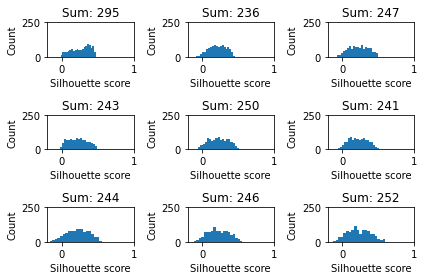

In [30]:
x = np.column_stack((rotated_data3[:,0],rotated_data3[:,1],rotated_data3[:,2]))

num_clusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([num_clusters,1])*np.NaN # init container to store sums

# Compute kMeans:
for i in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(i)).fit(x) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(x,cId) # compute the mean silhouette coefficient of all samples
    Q[i-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3,3,i-1)
    plt.hist(s,bins=20) 
    plt.xlim(-0.2,1)
    plt.ylim(0,250)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('Sum: {}'.format(int(Q[i-2]))) # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

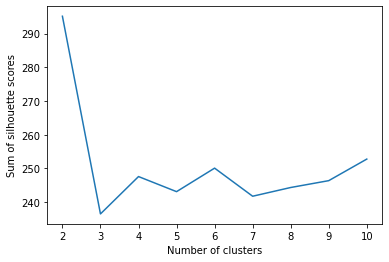

In [31]:
plt.plot(np.linspace(2,10,9),Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

In [32]:
# Using the first 3 principal components, we can say that:
# PC1 has to do with extraversion
# PC2 has to do with neuroticism
# PC3 has to do with introversion

In [33]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

<IPython.core.display.Javascript object>


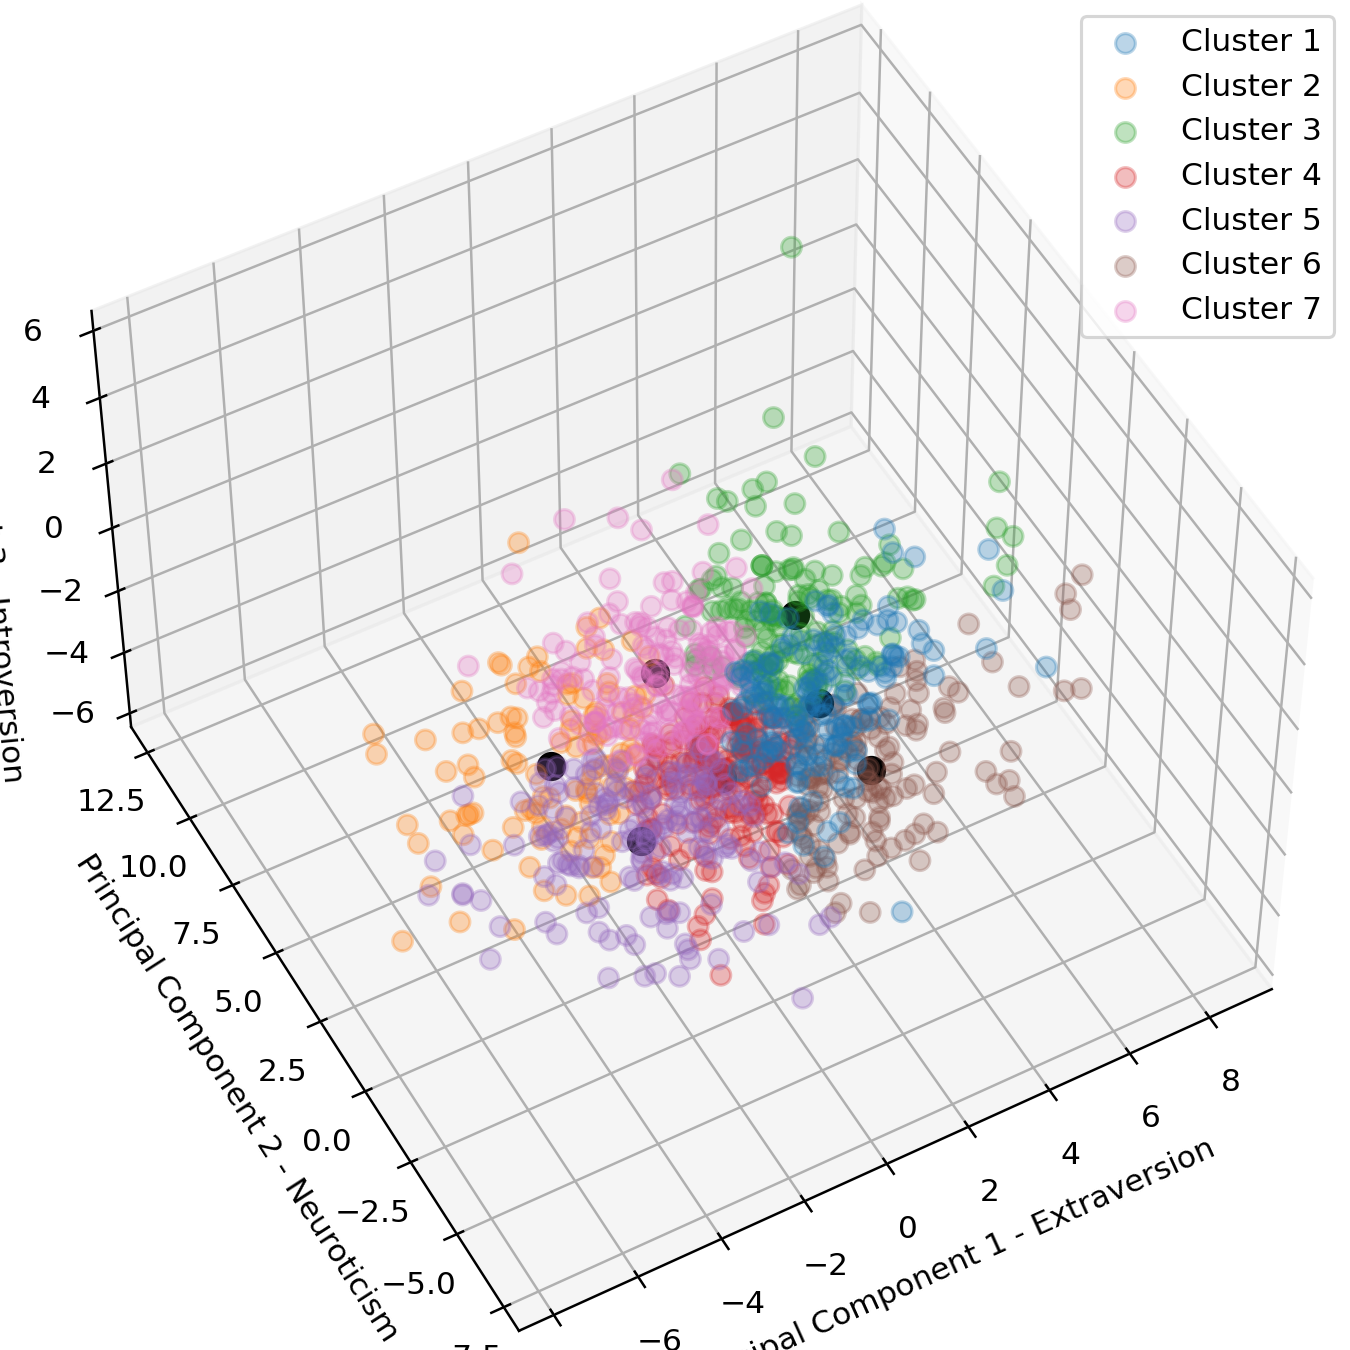

Text(0.5, 0, 'Principal Component 3 - Introversion')

In [34]:
%matplotlib notebook

num_clusters = 7
kMeans = KMeans(n_clusters = num_clusters).fit(np.column_stack((rotated_data3[:,0],rotated_data3[:,1],rotated_data3[:,2]))) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Plot the color-coded data:
for i in range(num_clusters):
    
    plotIndex = np.argwhere(cId == int(i))
    
    sc = ax.scatter(rotated_data3[plotIndex,0],
                    rotated_data3[plotIndex,1],
                    rotated_data3[plotIndex,2],
                    label=f'Cluster {i+1}',
                    s=40, marker='o', alpha=0.3)
    
    sc = ax.scatter(cCoords[int(i-1),0],
                    cCoords[int(i-1),1],
                    cCoords[int(i-1),2],
                    color='black', s=70)
    
ax.legend(loc='best')
ax.set_xlabel('Principal Component 1 - Extraversion')
ax.set_ylabel('Principal Component 2 - Neuroticism')
ax.set_zlabel('Principal Component 3 - Introversion')

In [ ]:
%matplotlib inline

# Statistical/Signifigcance Tests

### Question 3: Are movies that are more popular rated higher than movies that are less popular?

In [ ]:
# Do a median split of all movies by popularity: operationalizing the number of valid, non NaN entries each movies has
movie = data.iloc[:,:400]
movie_count = movie.count()
median = movie_count.median()

movie_median = movie.median(axis=0).to_frame().rename(columns={0: 'Median Rating'})
movie_median['Number of Responses'] = movie_count
movie_median['Greater than Median'] = np.where(movie_count >= median, 1, 0)

movie_more = movie.loc[:,(movie_count >= median)]
movie_less = movie.loc[:,(movie_count < median)]

more_median = movie_more.median(axis=0)
less_median = movie_less.median(axis=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [more_median, less_median]
title = ['Greater Than Median', 'Less Than Median']
colors = ['blue', 'orange']

kde1 = st.gaussian_kde(x[0])
kde2 = st.gaussian_kde(x[1])
lin = np.linspace(2, 4, 1000)

plt.hist(x, label=title, density=True, alpha=0.5, color=colors)
plt.plot(lin, kde1(lin), alpha=0.5)
plt.plot(lin, kde2(lin), alpha=0.5)

plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.legend(loc='best')
plt.title('Movie Popularity Ratings Comparison')
plt.tight_layout()

In [ ]:
U1, p1 = st.mannwhitneyu(more_median, less_median, alternative='greater')
U1, p1

In [ ]:
box = movie_median.boxplot(column='Median Rating', by='Greater than Median',
      grid=False)

box.set_title('')
box.set_ylabel('Rating')
box.set_xlabel('Greater than or Equal to Median (1 = yes, 2 = no)')

In [ ]:
D1, p1 = st.kstest(more_median, less_median)
D1, p1

### Question 4: Is enjoyment of ‘Shrek (2001)’ gendered, i.e. do male and female viewers rate it differently? 

In [ ]:
shrek = movie['Shrek (2001)']
gender_shrek = pd.concat([shrek, gender_identity], axis=1).dropna(axis=0)

male_shrek = gender_shrek.loc[gender_shrek['Gender identity (1 = female, 2 = male, 3 = self-described)'] == 2]
female_shrek = gender_shrek.loc[gender_shrek['Gender identity (1 = female, 2 = male, 3 = self-described)'] == 1]

male_shrek = male_shrek['Shrek (2001)']
female_shrek = female_shrek['Shrek (2001)']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [male_shrek, female_shrek]
title = ['Male Shrek Ratings', 'Female Shrek Ratings']
colors = ['blue', 'orange']

kde1 = st.gaussian_kde(x[0])
kde2 = st.gaussian_kde(x[1])
lin = np.linspace(0, 4, 1000)

plt.hist(x, label=title, density=True, alpha=0.5, color=colors)
plt.plot(lin, kde1(lin), alpha=0.5)
plt.plot(lin, kde2(lin), alpha=0.5)

plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.legend(loc='best')
plt.title('Male vs. Female Shrek (2001) Ratings')
plt.tight_layout()

In [ ]:
U3, p3 = st.mannwhitneyu(male_shrek, female_shrek)
U3, p3

In [ ]:
box = gender_shrek.boxplot(column='Shrek (2001)', by='Gender identity (1 = female, 2 = male, 3 = self-described)',
      grid=False)

box.set_title('')
box.set_ylabel('Response')

In [ ]:
D1, p1 = st.kstest(male_shrek, female_shrek)
D1, p1

### Question 5: Do people who are only children enjoy ‘The Lion King (1994)’ more than people with siblings?

In [ ]:
lion_king = movie['The Lion King (1994)']
sibship_lion = pd.concat([lion_king, sibship], axis=1).dropna(axis=0)

onlychild_lion = sibship_lion.loc[sibship_lion['Are you an only child? (1: Yes, 0: No, -1: Did not respond)'] == 1]
sibling_lion = sibship_lion.loc[sibship_lion['Are you an only child? (1: Yes, 0: No, -1: Did not respond)'] == 0]

onlychild_lion = onlychild_lion['The Lion King (1994)']
sibling_lion = sibling_lion['The Lion King (1994)']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [onlychild_lion, sibling_lion]
title = ['Only Child Effect on Lion King (1994) Ratings', 'Has Sibling Effect on Lion King (1994) Ratings']
colors = ['blue', 'orange']

kde1 = st.gaussian_kde(x[0])
kde2 = st.gaussian_kde(x[1])
lin = np.linspace(0, 4, 1000)

plt.hist(x, label=title, density=True, alpha=0.5, color=colors)
plt.plot(lin, kde1(lin), alpha=0.7)
plt.plot(lin, kde2(lin), alpha=0.7)

plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.legend(loc='best')
plt.title('Sibling Status on Lion King (1994) Ratings')
plt.tight_layout()

In [ ]:
U4, p4 = st.mannwhitneyu(onlychild_lion, sibling_lion, alternative='greater')
U4, p4

In [ ]:
box = sibship_lion.boxplot(column='The Lion King (1994)', by='Are you an only child? (1: Yes, 0: No, -1: Did not respond)',
      grid=False)

box.set_title('')
box.set_ylabel('Response')

In [ ]:
D1, p1 = st.kstest(onlychild_lion, sibling_lion)
D1, p1

### Question 6:	Do people who like to watch movies socially enjoy ‘The Wolf of Wall Street (2013)’ more than those who prefer to watch them alone?

In [ ]:
wolf = movie['The Wolf of Wall Street (2013)']
viewing_preference

wolf_preference = pd.concat([wolf, viewing_preference], axis=1).dropna(axis=0)

wolf_alone = wolf_preference.loc[wolf_preference['Movies are best enjoyed alone (1: Yes, 0: No, -1: Did not respond)'] == 1]
wolf_together = wolf_preference.loc[wolf_preference['Movies are best enjoyed alone (1: Yes, 0: No, -1: Did not respond)'] == 0]

wolf_alone = wolf_alone['The Wolf of Wall Street (2013)']
wolf_together = wolf_together['The Wolf of Wall Street (2013)']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [wolf_alone, wolf_together]
title = ['Wolf of Wall Street (2013) & Socially Preferred', 'Wolf of Wall Street (2013) Alone Preferred']
colors = ['blue', 'orange']

kde1 = st.gaussian_kde(x[0])
kde2 = st.gaussian_kde(x[1])
lin = np.linspace(0, 4, 1000)

plt.hist(x, label=title, density=True, alpha=0.5, color=colors)
plt.plot(lin, kde1(lin), alpha=0.7)
plt.plot(lin, kde2(lin), alpha=0.7)

plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.legend(loc='best')
plt.title('Wolf of Wall Street (2013) vs. Social Viewership Preference')
plt.tight_layout()

In [ ]:
U6, p6 = st.mannwhitneyu(wolf_together, wolf_alone, alternative='greater')
U6, p6

In [ ]:
box = wolf_preference.boxplot(column='The Wolf of Wall Street (2013)', by='Movies are best enjoyed alone (1: Yes, 0: No, -1: Did not respond)',
      grid=False)

box.set_title('')
box.set_ylabel('Response')

In [ ]:
D1, p1 = st.kstest(wolf_together, wolf_alone)
D1, p1

### Question 7:	There are ratings on movies from several franchises ([‘Star Wars’, ‘Harry Potter’, ‘The Matrix’, ‘Indiana Jones’, ‘Jurassic Park’, ‘Pirates of the Caribbean’, ‘Toy Story’, ‘Batman’]) in this dataset. How many of these are of inconsistent quality, as experienced by viewers? 

In [ ]:
# Will interpret inconsistent quality as ratings between movies, against one another is different
# Will operationalize quality to mean the median rating

star_wars = movie[['Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 
                   'Star Wars: Episode VI - The Return of the Jedi (1983)', 'Star Wars: Episode 1 - The Phantom Menace (1999)',
                   'Star Wars: Episode II - Attack of the Clones (2002)', 'Star Wars: Episode VII - The Force Awakens (2015)']]

harry_potter = movie[['Harry Potter and the Sorcerer\'s Stone (2001)', 'Harry Potter and the Goblet of Fire (2005)',
                      'Harry Potter and the Deathly Hallows: Part 2 (2011)']]

matrix = movie[['The Matrix (1999)', 'The Matrix Reloaded (2003)', 'The Matrix Revolutions (2003)']]

indiana_jones = movie[['Indiana Jones and the Last Crusade (1989)','Indiana Jones and the Temple of Doom (1984)', 
                       'Indiana Jones and the Kingdom of the Crystal Skull (2008)']]

jurassic_park = movie[['Jurassic Park (1993)', 'The Lost World: Jurassic Park (1997)', 'Jurassic Park III (2001)']]

pirates = movie[['Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Pirates of the Caribbean: Dead Man\'s Chest (2006)', 
                 'Pirates of the Caribbean: At World\'s End (2007)']]

toy_story = movie[['Toy Story (1995)', 'Toy Story 2 (1999)', 'Toy Story 3 (2010)']]

batman = movie[['Batman & Robin (1997)', 'Batman (1989)', 'The Dark Knight (2008)']]

In [ ]:
H1, p = st.kruskal(star_wars.iloc[:,0], star_wars.iloc[:,1], star_wars.iloc[:,2], star_wars.iloc[:,3],
           star_wars.iloc[:,4], star_wars.iloc[:,5], nan_policy='omit')
H1, p

In [ ]:
ax = sns.boxplot(data=star_wars)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H2, p = st.kruskal(harry_potter.iloc[:,0], harry_potter.iloc[:,1], harry_potter.iloc[:,2], nan_policy='omit')
H2, p

In [ ]:
ax = sns.boxplot(data=harry_potter.dropna(axis=0))
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H3, p = st.kruskal(matrix.iloc[:,0], matrix.iloc[:,1], matrix.iloc[:,2], nan_policy='omit')
H3, p

In [ ]:
ax = sns.boxplot(data=matrix)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H4, p = st.kruskal(indiana_jones.iloc[:,0], indiana_jones.iloc[:,1], indiana_jones.iloc[:,2], nan_policy='omit')
H4, p

In [ ]:
ax = sns.boxplot(data=indiana_jones)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H5, p = st.kruskal(jurassic_park.iloc[:,0], jurassic_park.iloc[:,1], jurassic_park.iloc[:,2], nan_policy='omit')
H5, p

In [ ]:
ax = sns.boxplot(data=jurassic_park)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H6, p = st.kruskal(pirates.iloc[:,0], pirates.iloc[:,1], pirates.iloc[:,2], nan_policy='omit')
H6, p

In [ ]:
ax = sns.boxplot(data=pirates)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H7, p = st.kruskal(toy_story.iloc[:,0], toy_story.iloc[:,1], toy_story.iloc[:,2], nan_policy='omit')
H7, p

In [ ]:
ax = sns.boxplot(data=toy_story)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
H8, p = st.kruskal(batman.iloc[:,0], batman.iloc[:,1], batman.iloc[:,2], nan_policy='omit')
H8, p

In [ ]:
ax = sns.boxplot(data=batman)
plt.setp(ax.get_xticklabels(), rotation=90)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics as default

#define plotting region (2 rows, 2 columns)
fig, ax = plt.subplots(2,4, figsize=(10,10))

#create boxplot in each subplot
g00 = sns.boxplot(data=star_wars, ax=ax[0,0])
g00.set(xticklabels=[])
g00.set(xlabel='Movie')
g00.set(title='Star Wars')

g01 = sns.boxplot(data=harry_potter, ax=ax[0,1])
g01.set(xticklabels=[])
g01.set(xlabel='Movie')
g01.set(title='Harry Potter')

g02 = sns.boxplot(data=matrix, ax=ax[0,2])
g02.set(xticklabels=[])
g02.set(xlabel='Movie')
g02.set(title='The Matrix')

g03 = sns.boxplot(data=indiana_jones, ax=ax[0,3])
g03.set(xticklabels=[])
g03.set(xlabel='Movie')
g03.set(title='Indiana Jones')

g10 = sns.boxplot(data=jurassic_park, ax=ax[1,0])
g10.set(xticklabels=[])
g10.set(xlabel='Movie')
g10.set(title='Jurassic Park')

g11 = sns.boxplot(data=pirates, ax=ax[1,1])
g11.set(xticklabels=[])
g11.set(xlabel='Movie')
g11.set(title='Pirates of the Carribbean')

g12 = sns.boxplot(data=toy_story, ax=ax[1,2])
g12.set(xticklabels=[])
g12.set(xlabel='Movie')
g12.set(title='Toy Story')

g13 = sns.boxplot(data=batman, ax=ax[1,3])
g13.set(xticklabels=[])
g13.set(xlabel='Movie')
g13.set(title='Batman')

# Prediction/ Regression Portion

### Question 8:	Build a prediction model of your choice (regression or supervised learning) to predict movie ratings (for all 400 movies) from personality factors only. Make sure to use cross-validation methods to avoid overfitting and characterize the accuracy of your model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import xgboost as xgb

In [ ]:
movie1 = movie.fillna(0)

X = rotated_data3[:,:8]
y = movie1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_personality1 = {}
for i in tqdm(range(len(y_train.iloc[0,:]))):

    xgb_model = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror', missing=0, seed=42)
    xgb_model = xgb_model.fit(X_train,
                              y_train.iloc[:,i],
                              verbose=True,
                              early_stopping_rounds=5,
                              eval_metric='rmse',
                              eval_set=[(X_test, y_test.iloc[:,i])])
    
    score = xgb_model.score
    
    y_pred = xgb_model.predict(X_test)
    predict = [value for value in y_pred]
    
    k_fold = KFold(n_splits=5)
    
    temp = {}
    temp['Model'] = xgb_model
    temp['R^2 Score'] = np.mean(cross_val_score(xgb_model, X_train, y_train.iloc[:,i], cv=k_fold, scoring='r2')) * -1
    temp['k-Fold Cross Validated RMSE'] = np.mean(cross_val_score(xgb_model,
                                                                  X_train,
                                                                  y_train.iloc[:,i],
                                                                  cv=k_fold, scoring='neg_root_mean_squared_error')) * -1
    
    xgb_personality1[movie.columns[i]] = temp

In [ ]:
cross_RMSE = []
for key in xgb_personality1.keys():
    cross_RMSE.append(xgb_personality1[key]['k-Fold Cross Validated RMSE'])

mean_RMSE = np.mean(cross_RMSE)

score = []
for key in xgb_personality1.keys():
    score.append(xgb_personality1[key]['R^2 Score'])

mean_score = np.mean(score)
    
print(f'Score: {mean_score}, Cross Validated RMSE: {mean_RMSE}')

### Question 9:	Build a prediction model of your choice (regression or supervised learning) to predict movie ratings (for all 400 movies) from gender identity, sibship status and social viewing preferences (columns 475-477) only. Make sure to use cross-validation methods to avoid overfitting and characterize the accuracy of your model. 

In [ ]:
# Initiates k-NN imputation across the movie experience characteristic
sys.setrecursionlimit(100000)

gsv = pd.concat([gender_identity, sibship, viewing_preference], axis=1)
gsv_impute = fast_knn(gsv.values, k=100)
gsv_impute = pd.DataFrame(gsv_impute, columns=gsv.columns)

In [ ]:
movie1 = movie.fillna(0)

X = gsv_impute
y = movie1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_personality2 = {}
for i in tqdm(range(len(y_train.iloc[0,:]))):

    xgb_model = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror', missing=0, seed=42)
    xgb_model = xgb_model.fit(X_train,
                              y_train.iloc[:,i],
                              verbose=True,
                              early_stopping_rounds=5,
                              eval_metric='rmse',
                              eval_set=[(X_test, y_test.iloc[:,i])])
    
    score = xgb_model.score
    
    y_pred = xgb_model.predict(X_test)
    predict = [value for value in y_pred]
    
    k_fold = KFold(n_splits=5)
    
    temp = {}
    temp['Model'] = xgb_model
    temp['R^2 Score'] = np.mean(cross_val_score(xgb_model, X_train, y_train.iloc[:,i], cv=k_fold, scoring='r2')) * -1
    temp['k-Fold Cross Validated RMSE'] = np.mean(cross_val_score(xgb_model, X_train, y_train.iloc[:,i], cv=k_fold, scoring='neg_root_mean_squared_error')) * -1
    
    xgb_personality2[movie.columns[i]] = temp

In [ ]:
cross_RMSE = []
for key in xgb_personality2.keys():
    cross_RMSE.append(xgb_personality2[key]['k-Fold Cross Validated RMSE'])

mean_RMSE = np.mean(cross_RMSE)

score = []
for key in xgb_personality2.keys():
    score.append(xgb_personality2[key]['R^2 Score'])

mean_score = np.mean(score)
    
print(f'Score: {mean_score}, Cross Validated RMSE: {mean_RMSE}')

### Question 10: Build a prediction model of your choice (regression or supervised learning) to predict movie ratings (for all 400 movies) from all available factors that are not movie ratings (columns 401 - 477). Make sure to use cross-validation methods to avoid overfitting and characterize the accuracy of your model. 

In [ ]:
all_avail = data.iloc[:,400:477]

# Initiates k-NN imputation across the movie experience characteristic
sys.setrecursionlimit(100000)

all_avail_impute = fast_knn(all_avail.values, k=100)
all_avail_impute = pd.DataFrame(all_avail_impute, columns=all_avail.columns)

In [ ]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

z_scored4 = st.zscore(all_avail_impute)

pca4 = PCA().fit(z_scored4)
eig_vals4 = pca4.explained_variance_
loadings4 = pca4.components_
rotated_data4 = pca4.fit_transform(z_scored4)

covar_explained4 = eig_vals4 / sum(eig_vals4) * 100

for n in range(len(covar_explained4)):
    explained4 = covar_explained4[n].round(5)
    print(f'The {ordinal(n)} PC explains {explained4}% of the variance')

In [ ]:
num_quest = len(all_avail.columns)
x = np.linspace(1,num_quest, num_quest)
plt.bar(x, eig_vals4, color='gray')
plt.plot([0,num_quest], [1,1], color='orange')
plt.title('All Available Factors Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
threshold = 1
print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals4 > threshold))

print('Number of factors selected by elbow criterion: 1')

threshold = 90
eig_sum4 = np.cumsum(covar_explained4)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum4 < threshold) + 1)

In [ ]:
look_at = 9
for i in range(0,look_at):
    
    plt.subplot(3,3,i+1)
    plt.bar(x, loadings4[i,:] * -1)
    
    plt.title(f'Principal Component {i+1}', fontsize=10)
    plt.xlabel('Question', fontsize=8)
    plt.ylabel('Loading', fontsize=8)
    
    plt.tight_layout()

In [ ]:
for index in range(len(all_avail.columns)):
    print(f'Principal component {index+1}: {all_avail.columns[index]}')

In [ ]:
movie1 = movie.fillna(0)

X = all_avail_impute
y = movie1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_personality3 = {}
for i in tqdm(range(len(y_train.iloc[0,:]))):

    xgb_model = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror', missing=0, seed=42)
    xgb_model = xgb_model.fit(X_train,
                              y_train.iloc[:,i],
                              verbose=True,
                              early_stopping_rounds=5,
                              eval_metric='rmse',
                              eval_set=[(X_test, y_test.iloc[:,i])])
    
    score = xgb_model.score
    
    y_pred = xgb_model.predict(X_test)
    predict = [value for value in y_pred]
    
    k_fold = KFold(n_splits=5)
    
    temp = {}
    temp['Model'] = xgb_model
    temp['R^2 Score'] = np.mean(cross_val_score(xgb_model, X_train, y_train.iloc[:,i], cv=k_fold, scoring='r2')) * -1
    temp['k-Fold Cross Validated RMSE'] = np.mean(cross_val_score(xgb_model, X_train, y_train.iloc[:,i], cv=k_fold, scoring='neg_root_mean_squared_error')) * -1
    
    xgb_personality3[movie.columns[i]] = temp

In [ ]:
cross_RMSE = []
for key in xgb_personality3.keys():
    cross_RMSE.append(xgb_personality3[key]['k-Fold Cross Validated RMSE'])

mean_RMSE = np.mean(cross_RMSE)

score = []
for key in xgb_personality3.keys():
    score.append(xgb_personality3[key]['R^2 Score'])

mean_score = np.mean(score)
    
print(f'Score: {mean_score}, Cross Validated RMSE: {mean_RMSE}')

### Question 11 (Extra credit): Tell us something interesting about this dataset that is not trivial and not already part of an answer (implied or explicitly) to these enumerated questions. 

In [ ]:
look_at = 9
for i in range(0,look_at):
    
    plt.subplot(3,3,i+1)
    plt.bar(x, loadings3[i,:] * -1)
    
    plt.title(f'Principal Component {i+1}', fontsize=10)
    plt.xlabel('Question', fontsize=8)
    plt.ylabel('Loading', fontsize=8)
    
    plt.tight_layout()

# Looking at the loadings of the personality data, the questions can be individually interpreted as factors of the Big Five OCEAN
# personality model

## Hints:
* In order to do some analyses, you might have to apply a dimension reduction method first. For instance, “sensation seeking” and “movie experience” are characterized by 10-20 variables each. You’ll need to distill their essence into much fewer factors first, before you can answer questions about the relationship between them. The same is true for personality, which is characterized by even more variables.

* In order to do some analyses, you will have to clean the data first, either by removing or imputing missing data (either is fine, but explain and justify what you did)

* If you encounter skewed data, you might want to transform the data before doing anything, e.g. zscoring, using log-transforms or the like.

* For some hypothesis tests, you will have to discretize the data, i.e. transform numerical values into categories so you can use them as categorical variables, e.g. by doing a median-split.

* You can interpret “types” as clusters here.

* You can operationalize the popularity of a movie by how many ratings it has received.

* Avoid overfitting with cross-validation

* The accuracy of your model can be stated with RMSE, R2 or AUC.

* You can use conventional choices of alpha (e.g. 0.05) or confidence intervals (e.g. 95%) throughout.

# Appendix

In [ ]:
PC = 0 # Which PC to take a look at
plt.bar(x, loadings3[PC,:] * -1)
plt.xlabel('Question')
plt.ylabel('Loading')
plt.show()

for i in range(len(personality.columns)):
    if loadings3[PC,i] * -1 > 0:
        print(f'(Positive) Principal component {i+1}: {personality.columns[i]}')

for i in range(len(personality.columns)):
    if loadings3[PC,i] * -1 < 0:
        print(f'(Negative) Principal component {i+1}: {personality.columns[i]}')

In [ ]:
more_ratings = more_ratings[~np.isnan(more_ratings)]
less_ratings = less_ratings[~np.isnan(less_ratings)]

import matplotlib.pyplot as plt
import numpy as np

x = [more_ratings, less_ratings]
title = ['Greater Than Median', 'Less Than Median']

for i in range(len(x)):
    
    plt.subplot(2,1,i+1) 
    plt.hist(x[i], bins=8)
    plt.ylabel('Frequency')
    plt.xlabel('Rating')
    plt.title(title[i])
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [more_median, less_median]
title = ['Greater Than Median', 'Less Than Median']

colors = ['blue', 'orange']

for i in range(len(x)):
    plt.subplot(2,1,i+1)
    plt.hist(x[i], bins=6, label=title[i], alpha=0.5, range=(2.0,4.0), color=colors[i])
    plt.ylabel('Count')
    plt.xlabel('Rating')
    plt.title('Movie Rating Movie Split')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
# movie = movie
# movie.columns = movie.columns.str.replace(' ', '_')
movie1 = movie.fillna(0)

X = rotated_data3[:,:8]
y = movie1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_personality = {}
for i in range(len(y_train.iloc[0,:])):
    y_train_dummies = pd.get_dummies(y_train.iloc[:,i])
    
    xgb_model = xgb.XGBClassifier(booster='gbtree', objective='reg:squarederror', missing=0, seed=42)